In [1]:
import os
import warnings
import numpy as np
import matplotlib.pyplot as plt
import cv2
import torch
import torch.nn as nn
import torchvision.transforms as transforms

from tqdm import tqdm, trange
from sklearn.manifold import TSNE
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from transformers import AutoImageProcessor, AutoModelForImageClassification

from segment.utils import loadModel, segment
from triplet import TripletImageFolder

SEED = 42
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
OUTPUT_DIR = "output/"
EMB_SIZE = 64
NUM_EPOCHS = 10

get_output_path = lambda path: os.path.join(OUTPUT_DIR, path)

print(f"DEVICE = {DEVICE}")
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

DEVICE = cuda


In [2]:
def mask_inputs(image):
    rl_mask, ll_mask, h_mask = segment(image / 255., segmodel, device=DEVICE)
    return (image * (rl_mask | ll_mask | h_mask).astype(int) / 255.).astype(np.float32)

In [3]:
segmodel = loadModel("models/weights.pt", torch.device("cuda"))

/h/wmloh/.local/lib/python3.9/site-packages/torch/nn/modules/instancenorm.py:80: UserWarning: input's size at dim=1 does not match num_features. You can silence this warning by not passing in num_features, which is not used because affine=False
  warnings.warn(f"input's size at dim={feature_dim} does not match num_features. "


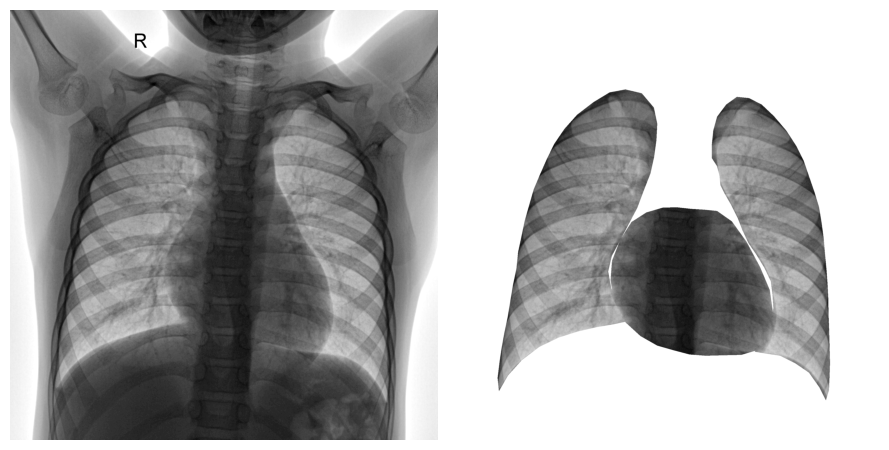

In [5]:
image = cv2.imread("sample.jpeg", 0)
plt.figure(figsize=(9, 5))

plt.subplot(121)
plt.imshow(image, "binary")
plt.axis("off")

plt.subplot(122)
plt.imshow(mask_inputs(image), "binary")
plt.axis("off")

plt.tight_layout()

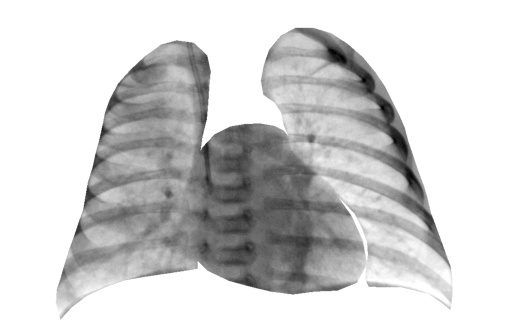

In [23]:
from PIL import Image

masked_img = transforms.Compose([transforms.Grayscale(),
                                 np.asarray,
                                 mask_inputs])(Image.fromarray(cv2.imread("data/train/PNEUMONIA/person10_bacteria_43.jpeg", 0)))
plt.imshow(masked_img, "binary")
plt.axis("off");

In [27]:
dataset = ImageFolder("data/test", transform=transforms.Compose([transforms.Grayscale(),
                                                                  np.asarray,
                                                                  mask_inputs,
                                                                  transforms.ToPILImage(),
                                                                  transforms.Grayscale(3),
                                                                  transforms.Resize((112, 112)),
                                                                  transforms.ToTensor()]))
dl = DataLoader(dataset, batch_size=16, shuffle=True)

dataset.class_to_idx

{'NORMAL': 0, 'PNEUMONIA': 1}

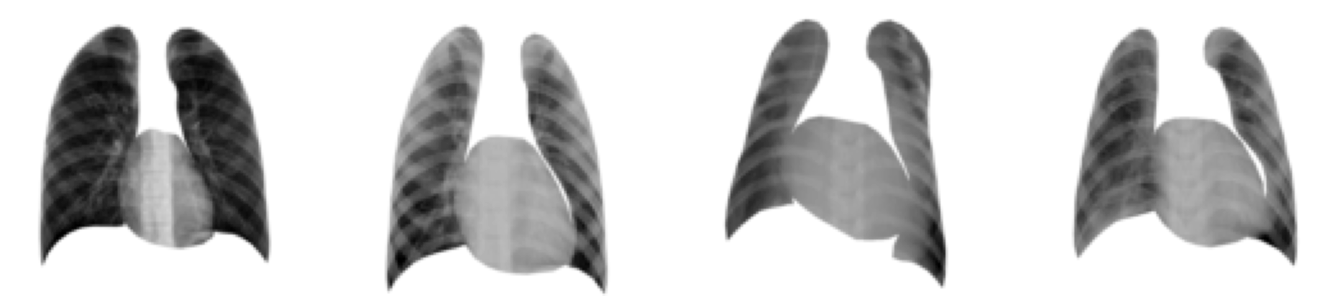

In [28]:
_, axs = plt.subplots(1, 4, figsize=(17, 5))
image_batch = next(iter(dl))[0]
for i in range(4):
    axs[i].imshow(image_batch[i][0] / 255., "binary")
    axs[i].axis("off")

In [24]:
# https://huggingface.co/microsoft/dit-large-finetuned-rvlcdip
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    processor = AutoImageProcessor.from_pretrained("microsoft/dit-large-finetuned-rvlcdip")
    model = AutoModelForImageClassification.from_pretrained("microsoft/dit-large-finetuned-rvlcdip")

model.classifier = nn.Linear(1024, EMB_SIZE)

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration. Please open a PR/issue to update `preprocessor_config.json` to use `image_processor_type` instead of `feature_extractor_type`. This warning will be removed in v4.40.


In [25]:
triplet_ds = TripletImageFolder(root="data/train", transform=transforms.Compose([transforms.Grayscale(),
                                                                                 np.asarray,
                                                                                 mask_inputs,
                                                                                 transforms.ToPILImage(),
                                                                                 transforms.Grayscale(3),
                                                                                 transforms.Resize((112, 112)),
                                                                                 transforms.ToTensor()]))
triplet_dl = DataLoader(triplet_ds, batch_size=16, shuffle=True)

In [29]:
image_batch = np.asarray((next(iter(dl))[0] / 255.), dtype=np.uint8)
inputs = processor(images=image_batch, return_tensors="pt")
outputs = model(**inputs)
print(outputs.logits.shape)

torch.Size([16, 64])


In [30]:
optim = torch.optim.Adam(model.parameters(), lr=8e-4)
loss_fn = nn.TripletMarginLoss()

In [31]:
model.train()
model.to(DEVICE)

for e in range(1):
    for i, (anc, pos, neg) in enumerate(tqdm(triplet_dl, total=len(triplet_dl))):
        anc = anc.to(DEVICE)
        pos = pos.to(DEVICE)
        neg = neg.to(DEVICE)
        loss = loss_fn(model(anc).logits, model(pos).logits, model(neg).logits)
        
        optim.zero_grad()
        loss.backward()
        optim.step()
    
model.eval()
model.cpu();

  4%|▍         | 13/327 [01:01<24:36,  4.70s/it]


KeyboardInterrupt: 

## Visualization

In [32]:
test_dataset = ImageFolder("data/test", transform=transforms.Compose([transforms.Grayscale(),
                                                                  np.asarray,
                                                                  mask_inputs,
                                                                  transforms.ToPILImage(),
                                                                  transforms.Grayscale(3),
                                                                  transforms.Resize((112, 112)),
                                                                  transforms.ToTensor()]))
test_dl = DataLoader(test_dataset, batch_size=128, shuffle=True)

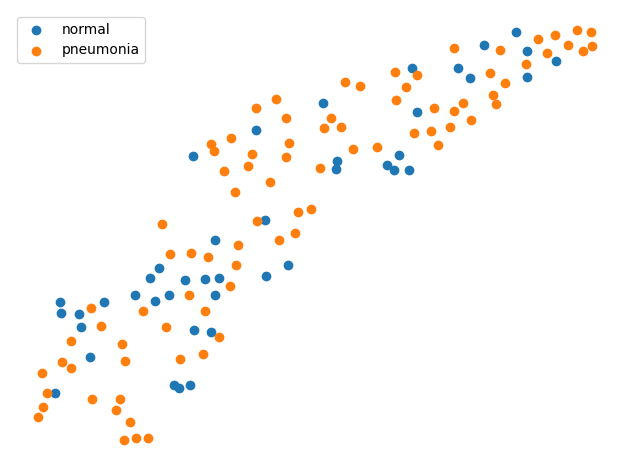

In [34]:
model.eval()
model.cpu()

X, y = next(iter(test_dl))
with torch.no_grad():
    X_emb = model(X).logits
X_red = TSNE(perplexity=25).fit_transform(X_emb.numpy())

plt.scatter(*X_red[y == 0].T, label="normal")
plt.scatter(*X_red[y == 1].T, label="pneumonia")
plt.legend()
plt.axis("off")

plt.tight_layout()